In [6]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
 
import numpy as np

import os
# os.chdir("/gpfs/commons/home/daknowles/pooledRBPs/src/") # just needed for running via Colab

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/")

# load input RNA allelic counts
input_files = [ "/gpfs/commons/home/mschertzer/asb_model/all-input-rep1_allelic.out", # this is bio rep 1 (two sequencing runs combined)
               "/gpfs/commons/home/mschertzer/pilot_pool/allelic/technical_rep1/input-rep2_allelic.out"] # bio rep 2, low sequencing depth

input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files ]

# observed genotype data (after running StrandScript)
geno = io_utils.loadGenotypes('/gpfs/commons/home/phalmos/genotypes/CIRMlines_flipped.vcf', 
                     maxlines = None, 
                     posterior = False).rename(columns = {"SNP" : "variantID"})

In [7]:
geno

,position,contig,variantID,refAllele,altAllele,CW30274-1-1194512543_CW30274-1-1194512543,CW30454-1-1194512472_CW30454-1-1194512472,CW30421-1-1194512512_CW30421-1-1194512512,CW70372-1-1194512488_CW70372-1-1194512488,CW40201-1-1194512480_CW40201-1-1194512480,CW30525-1-1194512464_CW30525-1-1194512464,CW30190-1-1194512504_CW30190-1-1194512504,CW30108-1-1194512496_CW30108-1-1194512496,CW30154-1-1194512551_CW30154-1-1194512551,CW70179-1-1194512535_CW70179-1-1194512535,CW70142-1-1194512527_CW70142-1-1194512527
rs3131972,752721,chr1,rs3131972,G,A,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5
rs11240777,798959,chr1,rs11240777,G,A,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.5
rs4970383,838555,chr1,rs4970383,N,.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rs4475691,846808,chr1,rs4475691,C,T,0.5,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.0
rs13302982,861808,chr1,rs13302982,G,A,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MitoA16164G,16163,chr26,MitoA16164G,A,.,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MitoC16272T,16270,chr26,MitoC16272T,C,T,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
MitoG16393A,16391,chr26,MitoG16393A,G,.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-08-MT-511,16399,chr26,2010-08-MT-511,A,G,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Deconvolution

sum(w)=0.987529 ideally would be 1


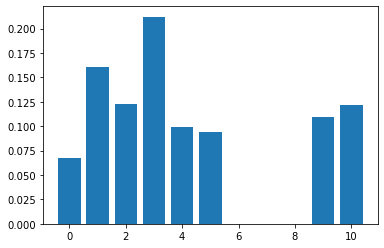

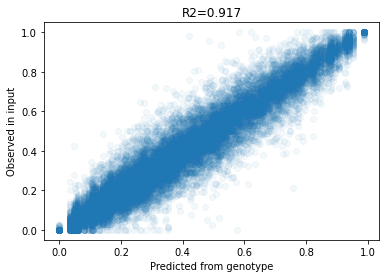

sum(w)=0.986087 ideally would be 1


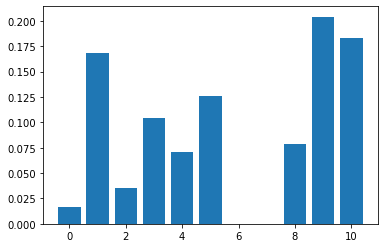

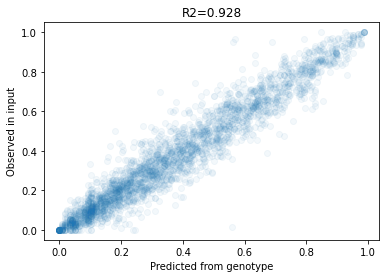

In [8]:
w = [ deconvolve.deconvolve(geno, inp) for inp in input_counts ]

In [9]:
props = pd.DataFrame(w).transpose()
props.columns = ["rep1","rep2"]
props["line"] = geno.columns[5:16]
props.iloc[:,[2,0,1]].to_csv(results_dir / "deconv.tsv", index = False, sep = "\t")

props

,rep1,rep2,line
0,0.067854,0.016107,CW30274-1-1194512543_CW30274-1-1194512543
1,0.160609,0.167875,CW30454-1-1194512472_CW30454-1-1194512472
2,0.123022,0.035715,CW30421-1-1194512512_CW30421-1-1194512512
3,0.212105,0.103827,CW70372-1-1194512488_CW70372-1-1194512488
4,0.098892,0.071163,CW40201-1-1194512480_CW40201-1-1194512480
5,0.093769,0.125951,CW30525-1-1194512464_CW30525-1-1194512464
6,0.000000,0.000000,CW30190-1-1194512504_CW30190-1-1194512504
7,0.000256,0.000000,CW30108-1-1194512496_CW30108-1-1194512496
8,0.000000,0.078558,CW30154-1-1194512551_CW30154-1-1194512551
9,0.109172,0.204062,CW70179-1-1194512535_CW70179-1-1194512535


# Load and check imputed genotypes

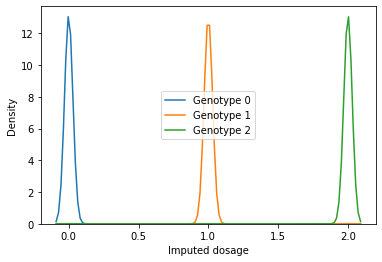

In [10]:
# load sanger (and cache) imputed data
sanger_feather = Path("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.feather")
if sanger_feather.is_file(): 
    sanger = pd.read_feather(sanger_feather)
    del sanger["index"]
else: # this is pretty slow to read, so cache to feather
    sanger = io_utils.loadGenotypes("/gpfs/commons/home/daknowles/pooledRBPs/genotypes/sanger.vcf.gz", 
                           maxlines = None, 
                           posterior = True,
                           posterior_index = 2,
                          print_every = 10000) 
    sanger.reset_index().to_feather(sanger_feather)

cirm_lines = sanger.columns[5:16]
sanger_merge = geno.rename(columns = {"variantID" : "SNP"}).merge(sanger, on = ["SNP","refAllele","altAllele"], suffixes = ("_geno","_imp"))
geno_geno = sanger_merge.loc[:,cirm_lines.astype(str) + "_geno"].to_numpy()
geno_imp = sanger_merge.loc[:,cirm_lines.astype(str) + "_imp"].to_numpy()

### check imputation looks sensible on genotyped variants 
sns.kdeplot(geno_imp[geno_geno==0.], bw = 0.03, label = "Genotype 0")
sns.kdeplot(geno_imp[geno_geno==.5], bw = 0.03, label = "Genotype 1")
sns.kdeplot(geno_imp[geno_geno==1.], bw = 0.03, label = "Genotype 2")
plt.xlabel("Imputed dosage")
plt.ylabel("Density")
plt.legend()
plt.show() # nice! 

# Load IP count data and join with input and genotype

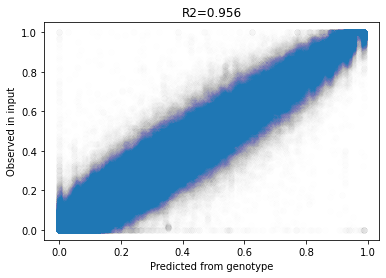

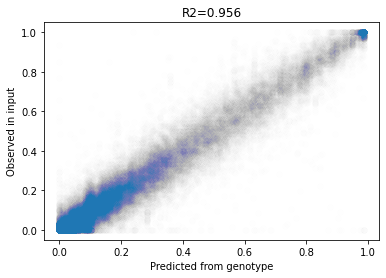

In [11]:
IP_files = [ "/gpfs/commons/home/mschertzer/asb_model/all_hnrnpk-rep1_allelic.out", 
             "/gpfs/commons/home/mschertzer/pilot_pool/allelic/technical_rep1/hnrnpk-rep2_allelic.out" ]
IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files ]

merged,dat_sub = deconvolve.merge_geno_and_counts(sanger, input_counts[0], IP_counts[0], w[0], plot = True)
merged_2,dat_sub_2 = deconvolve.merge_geno_and_counts(sanger, input_counts[1], IP_counts[1], w[1], plot = True,
        input_total_min = 10, allele_count_min = 2, ip_total_min = 10) # more lenient thresholds for lower seq depth

dat_sub["input_ratio"] = dat_sub.altCount_input / dat_sub.totalCount_input
dat_sub["IP_ratio"] = dat_sub.altCount_IP / dat_sub.totalCount_IP

# Run beta models

This can't handle replicates. 

Mean field guide
{'input_conc': 47.72235107421875, 'input_count_conc': 66.02518463134766, 'IP_conc': 15.508841514587402, 'IP_count_conc': 53.20222091674805}


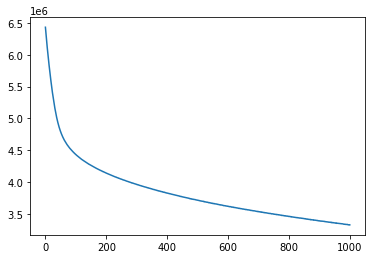

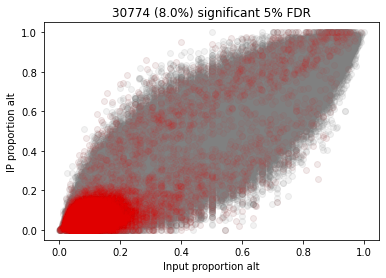

         position_x contig    variantID refAllele altAllele contig_y  \
1825881    46847417  chr21   rs35015575         G         A    chr21   
2428696   152557560   chr3    rs1063103         C         T     chr3   
2428924   152881396   chr3   rs73872931         T         G     chr3   
3411119    42026968   chr8   rs34361836         A         T     chr8   
450924     69665309  chr12   rs11608640         T         C    chr12   
2429476   153964574   chr3   rs76557547         A         G     chr3   
450891     69647278  chr12   rs12831239         A         G    chr12   
450885     69645598  chr12   rs35583275         C         T    chr12   
450876     69642792  chr12   rs12815331         C         T    chr12   
450871     69640501  chr12   rs34173894         C         G    chr12   
450853     69636224  chr12   rs79199301         G         A    chr12   
2430183   154894805   chr3    rs3773874         C         A     chr3   
2430184   154895383   chr3   rs71310424         G         A     

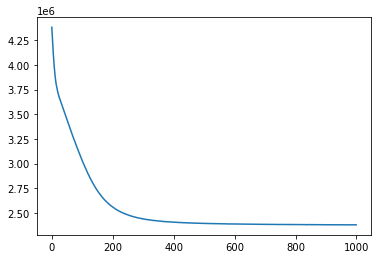

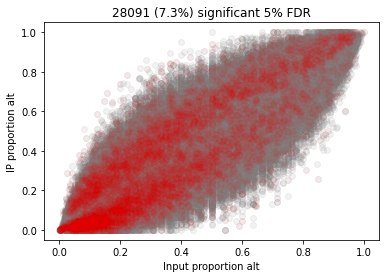

         position_x contig    variantID refAllele altAllele contig_y  \
3478661   113210935   chr8  rs146619362         C         T     chr8   
1887893    45188400  chr22   rs13054821         G         T    chr22   
1466177    45319265   chr1    rs6688465         T         C     chr1   
118902     92533729  chr10    rs7086484         G         A    chr10   
1335591    36752691  chr19   rs62113154         T         C    chr19   
2143498   201303010   chr2    rs2028201         G         T     chr2   
45212      26012163  chr10    rs2442876         T         A    chr10   
1335597    36753362  chr19    rs2918358         G         T    chr19   
3559940    23669912   chr9    rs1410845         C         G     chr9   
2594508    88847495   chr4   rs11097177         G         A     chr4   
1000074    70654728  chr16   rs34878593         C         T    chr16   
2812701   109166187   chr5     rs759810         T         G     chr5   
2212369     6553664   chr3   rs75284943         G         A     

In [12]:
device = "cpu"
data = asb_data.RelativeASBdata.from_pandas(dat_sub, device = device)

for use_structured_guide in (False,True):

    print("Structured guide" if use_structured_guide else "Mean field guide")
    
    losses, model, guide, stats, samples = beta_model.fit(data, use_structured_guide = use_structured_guide)

    plt.plot(losses)
    plt.show()
    losses[-1] # 133094 compared to 117421 for structured SVI (so guess latter is better)

    p = (samples["input_ratio"] > samples["IP_ratio"]).float().mean(0).squeeze().numpy()

    # proportion significant
    dat_sub["q"] = np.minimum(p,1.-p)
    
    effect_size = torch.logit(samples["IP_ratio"]) - torch.logit(samples["input_ratio"])
    dat_sub["effect_mean"] = effect_size.mean(0).squeeze().numpy()
    dat_sub["effect_std"] = effect_size.std(0).squeeze().numpy()

    dat_sub.drop(columns = ["input_ratio", "IP_ratio"]
                ).to_csv(results_dir / ("beta" + ("_struct" if use_structured_guide else "") + "_results.tsv.gz"), 
                         index = False, sep = "\t")

    plt.scatter(dat_sub.input_ratio, dat_sub.IP_ratio,alpha=0.1, color="gray")
    dat_ss = dat_sub[dat_sub.q < fdr_threshold]
    plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.03, color = "red")
    plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
    plt.title('%i (%.1f%%) significant %.0f%% FDR' % ((dat_sub["q"] < 0.1).sum(), 100. * (dat_sub["q"] < 0.1).mean(), fdr_threshold*100))
    plt.show()
    
    print(dat_sub.sort_values("q").head(20))


# Normal model without replicates

Could also run this with the mean field guide. 

{'ase_scale': 0.21841275691986084, 'input_count_conc': 406.3957824707031, 'asb_scale': 0.2433781921863556, 'IP_count_conc': 339.12957763671875, 'ase_t_df': 4.689060688018799, 'asb_t_df': 32.515201568603516}


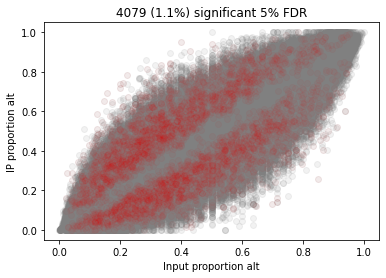

,position_x,contig,variantID,refAllele,altAllele,contig_y,position,refCount_input,altCount_input,totalCount_input,allelic_ratio,pred_ratio,refCount_IP,altCount_IP,totalCount_IP,input_ratio,IP_ratio,q,effect_mean,effect_std
2599142,92549561,chr4,rs4376107,A,G,chr4,91628410,84,184,268,0.686567,0.553320,508,1775,2283,0.686567,0.777486,0.0,0.397636,0.129655
119111,92568958,chr10,rs12761148,T,C,chr10,90809201,169,117,286,0.409091,0.414174,827,904,1731,0.409091,0.522241,0.0,0.307235,0.121129
2084172,153468107,chr2,rs35776654,C,T,chr2,152611593,264,129,393,0.328244,0.303512,91,19,110,0.328244,0.172727,0.0,-0.431835,0.170236
1839088,21338146,chr22,rs62238539,G,A,chr22,20983857,14,10,24,0.416667,0.318137,113,122,235,0.416667,0.519149,0.0,0.400600,0.151243
842108,65108479,chr15,rs8036568,T,C,chr15,64816280,536,68,604,0.112583,0.117300,265,92,357,0.112583,0.257703,0.0,0.513180,0.159228
2594552,88853670,chr4,rs12504187,T,C,chr4,87932518,330,133,463,0.287257,0.809304,53,234,287,0.287257,0.815331,0.0,1.834158,0.307337
3459435,97243634,chr8,rs36123415,G,A,chr8,96231406,101,118,219,0.538813,0.164488,340,72,412,0.538813,0.174757,0.0,-1.014781,0.210947
1828485,47661163,chr21,rs17183318,T,C,chr21,46241249,48,46,94,0.489362,0.362249,202,77,279,0.489362,0.275986,0.0,-0.368104,0.141089
1888827,45323933,chr22,rs9614986,A,C,chr22,44928053,28,76,104,0.730769,0.601653,113,123,236,0.730769,0.521186,0.0,-0.432786,0.132047
563916,36892480,chr13,rs137876146,G,A,chr13,36318343,37,26,63,0.412698,0.312728,94,285,379,0.412698,0.751979,0.0,0.948576,0.249372


In [13]:
losses, model, guide, stats, samples = gaussian_model.fit(data, use_structured_guide = True)

{ k:v["mean"].item() for k,v in stats.items() if v["mean"].numel() ==1 }

p = (samples['asb'] > 0.).float().mean(0).squeeze().numpy()

dat_sub["q"] = np.minimum(p,1.-p)
dat_sub["effect_mean"] = samples["asb"].mean(0).squeeze().numpy()
dat_sub["effect_std"] = samples["asb"].std(0).squeeze().numpy()

fdr_threshold = 0.05
plt.scatter(dat_sub.input_ratio, dat_sub.IP_ratio,alpha=0.1, color="gray")
dat_ss = dat_sub[dat_sub.q < fdr_threshold]
plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.03, color = "red")
plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
plt.title('%i (%.1f%%) significant %.0f%% FDR' % ((dat_sub["q"] < fdr_threshold).sum(), 100. * (dat_sub["q"] < fdr_threshold).mean(), 100 * fdr_threshold))
plt.show()

dat_sub.drop(columns = ["input_ratio", "IP_ratio"]).to_csv(results_dir / "normal_struct_results.tsv.gz", index = False, sep = "\t")

dat_sub.sort_values("q").head(20)

# Replicates model

In [ ]:
#both = pd.concat( [dat_sub.merge( dat_sub_2.loc[:,["variantID"]], on = "variantID"), # only shared SNPs
#                dat_sub_2.merge( dat_sub.loc[:,["variantID"]], on = "variantID")], axis = 0)
both = pd.concat( (dat_sub, dat_sub_2), axis = 0)

data_both = asb_data.ReplicateASBdata.from_pandas(both)

losses, model, guide, stats, samples = gaussian_model.fit(data_both, use_structured_guide = True)

both["IP_ratio"] = both.altCount_IP / both.totalCount_IP

asb_loc = pyro.param("asb_loc").detach().numpy() # ~= samples["asb"].mean(0).squeeze().numpy()
asb_sd = torch.sqrt(pyro.param("asb_scale_param")**2 + pyro.param("asb_corr")**2).detach().numpy() # ~= samples["asb"].std(0).squeeze().numpy()

both["effect_mean"] = asb_loc[data_both.snp_indices]
both["effect_std"] = asb_sd[data_both.snp_indices]

q = scipy.stats.norm().cdf(-np.abs(asb_loc / asb_sd))
both["q"] = q[data_both.snp_indices]
both.sort_values("q").head(20)

both.drop(columns = ["input_ratio", "IP_ratio"]).to_csv(results_dir / "rep_struct_results.tsv.gz", index = False, sep = "\t")

both.sort_values("q").head(20)

Plotting is a bit more complicated because we have two reps. So just look at counts for rep 1. 

In [ ]:
snp_lookup = both.loc[:,["contig","position","position_x","variantID"]].drop_duplicates().rename(columns = {"position_x" : "position_hg19"})
res = pd.DataFrame( {"variantID" : data_both.snps, "q" : q, "asb_mean" : asb_loc, "asb_sd" : asb_sd })
res = snp_lookup.merge( res, on = "variantID" )
res.to_csv(results_dir / "rep_struct_asb.tsv.gz", index = False, sep = "\t")

to_plot = res.loc[:,["variantID","q"]].merge(dat_sub.loc[:,["variantID","input_ratio","totalCount_input","IP_ratio","totalCount_IP",]], on = "variantID")

plt.scatter(to_plot.input_ratio, to_plot.IP_ratio,alpha=0.1, color="gray")
dat_ss = to_plot[to_plot.q < fdr_threshold]
plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.03, color = "red")
plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
plt.title('%i (%.1f%%) significant %.0f%% FDR' % ((res["q"] < fdr_threshold).sum(), 100. * (res["q"] < fdr_threshold).mean(), 100 * fdr_threshold))
plt.show()

In [ ]:
to_plot["totalCount_IP_bin"] = pd.cut(to_plot.totalCount_IP, [30,60,100,300,1000,np.inf], precision = -1)
to_plot["totalCount_input_bin"] = pd.cut(to_plot.totalCount_input, [9,30,60,100,300,1000,np.inf], precision = -1)
to_plot["asb"] = to_plot.q < fdr_threshold
to_plot["one"] = 1.
agg = to_plot.groupby(["totalCount_IP_bin","totalCount_input_bin"]).agg({"asb" : "mean", "one" : "sum"}).reset_index()
df_wide = agg.pivot_table( index='totalCount_IP_bin', columns='totalCount_input_bin', values='asb')
plt.figure(figsize=(10,6))
sns.heatmap(df_wide, annot = True)

df_wide = agg.pivot_table( index='totalCount_IP_bin', columns='totalCount_input_bin', values='one')
plt.figure(figsize=(10,6))
sns.heatmap(df_wide, annot = True)

In [ ]:
z = asb_loc / asb_sd
nu = np.random.normal(size=len(z))

plt.rcParams.update({'font.size': 14})
f, ax = plt.subplots(figsize=(6, 4))
plt.hist(z,log=True, bins=100, alpha=0.5, label = "Data")
plt.hist(nu,log=True, bins=100, alpha = 0.5, label = "Null")
plt.legend()
plt.xlabel("Z-score")
plt.ylabel("Count")
plt.savefig("asb.pdf")
plt.show()